**Тут мы чуть-чуть поработаем со старыми данными и создадим модель логистической регрессии.**

## Импортируем все, что нам пригодится.

In [727]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rc("font", size=14)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score,roc_auc_score, roc_curve, auc
from sklearn.linear_model import LogisticRegressionCV
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

**Берем полученные данные, полученные на предыдущем шаге, за 3 первых календарных дня с момента первого действия пользователя. Мы также считаем, что студент дропнулся, если он не заходил в течение 30 дней**

In [728]:
X = pd.read_csv('X_3_30.csv')
y = pd.read_csv('y_3_30.csv')

## Важно: чтобы не запутаться, мы поменяем местами 0 и 1 в зависимой переменной "y", чтобы 1 у нас означала - студент дропнулся, а 0 - нет. Также переименуем название колонку в is_dropped, чтобы внести ясность.

In [729]:
df = pd.DataFrame(np.logical_xor(y.values,1).astype(int),columns=y.columns, index=y.index).rename(columns={'passed_course': 'is_dropped'})

In [730]:
df.head()

,Unnamed: 0,is_dropped
0,1,1
1,0,1
2,0,1
3,0,1
4,0,0


In [731]:
y = df.is_dropped

In [732]:
X = X.set_index(X.user_id)
X = X.drop('user_id', axis=1)

In [733]:
X.head()

,days,steps_tried,correct,wrong,correct ratio,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.00,9
3,1.0,4.0,4.0,4.0,0.50,20
8,1.0,11.0,9.0,21.0,0.30,154
14,1.0,1.0,0.0,1.0,0.00,9
16,3.0,23.0,23.0,27.0,0.46,132


**index - user_id,**
**days - количество уникальных дней, когда пользователь заходил,**
**steps_tried - количество уроков, которые студент пробовал пройти,**
**correct - количество правильных ответов,**
**wrong - количество неправильных ответов,**
**correct ratio - доля правильных ответов,**
**viewed - количество просмотренных уроков (но не обязательно пройденных),**

### Немного поанализируем наши данные

In [734]:
y.value_counts()

1    16560
0     1425
Name: is_dropped, dtype: int64

**Создадим новый датасет, в котором объединим все наши данные, чтобы немного порисовать.**

In [735]:
full_data = X
full_data['y'] = y.values

In [736]:
full_data.head()

,days,steps_tried,correct,wrong,correct ratio,viewed,y
user_id,,,,,,,
2,1.0,2.0,2.0,0.0,1.00,9,1
3,1.0,4.0,4.0,4.0,0.50,20,1
8,1.0,11.0,9.0,21.0,0.30,154,1
14,1.0,1.0,0.0,1.0,0.00,9,1
16,3.0,23.0,23.0,27.0,0.46,132,0


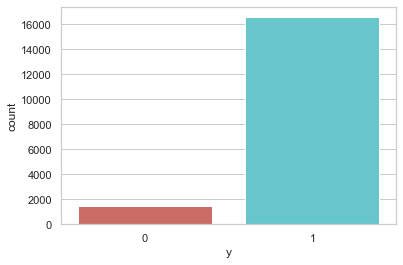

In [737]:
sns.countplot(x='y',data=full_data, palette='hls')
plt.show()

In [738]:
count_no_drop = len(full_data[full_data['y']==1])
count_drop = len(full_data[full_data['y']==0])
pct_of_no_drop = count_no_drop/(count_no_drop+count_drop)
print("percentage of drop is", pct_of_no_drop*100)
pct_of_drop = count_drop/(count_no_drop+count_drop)
print("percentage of no drop", pct_of_drop*100)

percentage of drop is 92.07673060884069
percentage of no drop 7.923269391159299


**Опять-таки, проверяем себя. 8% прошедших курс - норма в отрасли. Странно было бы увидеть 80%.**

In [739]:
full_data.groupby('y').mean()

,days,steps_tried,correct,wrong,correct ratio,viewed
y,,,,,,
0,1.917193,14.003509,14.059649,12.905263,0.600396,65.640000
1,0.593056,2.720773,2.680435,2.550362,0.304214,17.856643


**Ушедшие проявляли куда меньшую активность и, кажется, все фичи имеют значение.**

##  На всякий случай посмотрим гистограммы

Text(0, 0.5, 'Drops')

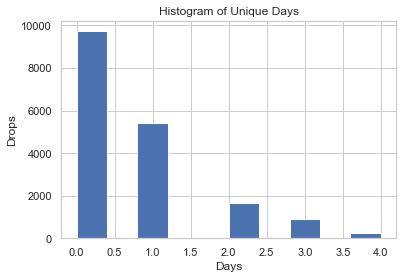

In [740]:
full_data.days.hist()
plt.title('Histogram of Unique Days')
plt.xlabel('Days')
plt.ylabel('Drops')

Text(0, 0.5, 'Drops')

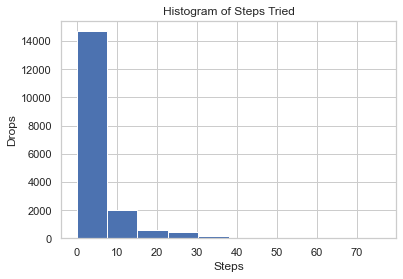

In [741]:
full_data.steps_tried.hist()
plt.title('Histogram of Steps Tried')
plt.xlabel('Steps')
plt.ylabel('Drops')

Text(0, 0.5, 'Drops')

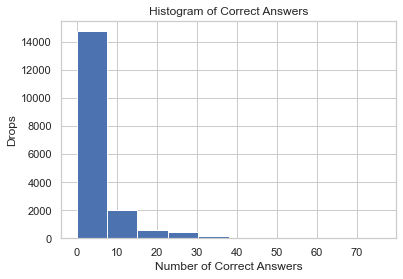

In [742]:
full_data.correct.hist()
plt.title('Histogram of Correct Answers')
plt.xlabel('Number of Correct Answers')
plt.ylabel('Drops')

Text(0, 0.5, 'Drops')

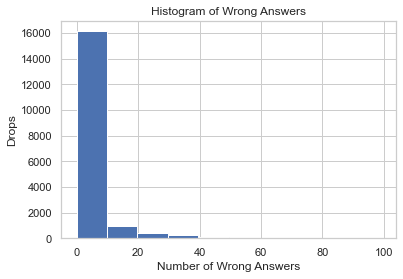

In [743]:
full_data.wrong[full_data['wrong'] < 100].hist()
plt.title('Histogram of Wrong Answers')
plt.xlabel('Number of Wrong Answers')
plt.ylabel('Drops')

Text(0, 0.5, 'Drops')

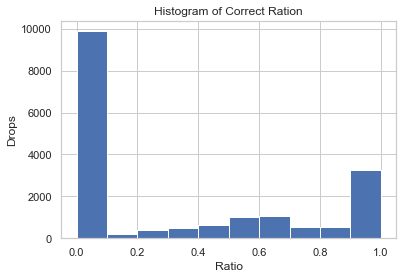

In [744]:
full_data['correct ratio'].hist()
plt.title('Histogram of Correct Ration')
plt.xlabel('Ratio')
plt.ylabel('Drops')

Text(0, 0.5, 'Drops')

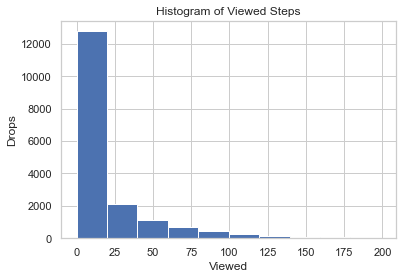

In [745]:
full_data.viewed[full_data.viewed<200].hist()
plt.title('Histogram of Viewed Steps')
plt.xlabel('Viewed')
plt.ylabel('Drops')

**В общем, убедились, что ушедшие проявляли меньшую активность.**

In [746]:
X.head()

,days,steps_tried,correct,wrong,correct ratio,viewed,y
user_id,,,,,,,
2,1.0,2.0,2.0,0.0,1.00,9,1
3,1.0,4.0,4.0,4.0,0.50,20,1
8,1.0,11.0,9.0,21.0,0.30,154,1
14,1.0,1.0,0.0,1.0,0.00,9,1
16,3.0,23.0,23.0,27.0,0.46,132,0


In [747]:
X = X.drop('y', axis=1)

## Создадим модель логистической регрессии.

In [748]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

clf = LogisticRegressionCV(cv=5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
log_reg_dict = {
    'Precision Score': precision_score(y_test, y_pred),
    'Recall Score': recall_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred)
}

## Взглянем на матрицу ошибок.

array([[  37,  199],
       [  42, 3319]], dtype=int64)

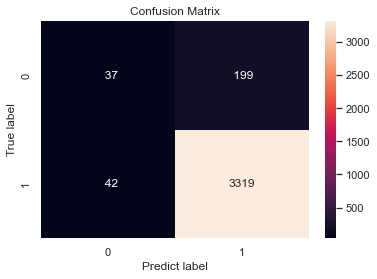

In [749]:
conf_mx = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mx, annot=True, fmt='4.0f')
plt.title('Confusion Matrix')
plt.xlabel('Predict label')
plt.ylabel('True label')
conf_mx

In [750]:
log_reg_dict

{'Precision Score': 0.9434337691870381,
 'Recall Score': 0.9875037191312109,
 'F1 Score': 0.9649658380578572}

Вот этого уже хорошо. Стоило поменять местами 0 и 1 в зависимой переменной исходных данных.

## Осталось построить ROC-кривую.

**Получим прогнозы модели логистической регрессии в виде значений вероятности и оставим вероятности только для положительного исхода.**

In [751]:
y_hat = clf.predict_proba(X_test)[:,1]

**Рассчитаем ROC-AUC.**

In [752]:
lr_auc = roc_auc_score(y_test, y_hat)
print('LogisticRegression: ROC AUC=%.3f' % lr_auc)

LogisticRegression: ROC AUC=0.817


**Рассчитываем ROC-кривую и построим график.**


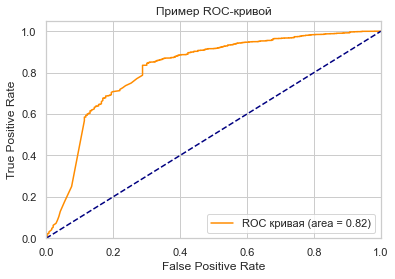

In [753]:
fpr, tpr, threshold = roc_curve(y_test, y_hat)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Пример ROC-кривой')
plt.legend(loc="lower right")
plt.show()

**Замечательно! Результат больше 0.8, что для нашей модели вполне достаточно.**

## Резюме.
**Мы построили неплохую модель на основе данных, полученных в файле "Get Data". У нас получилось предсказать за первые 3 календарных дня поведение студента, а именно: пройдет ли он курс полностью или уйдет. И теперь мы можем студентам, склонным уйти, предлагать лучшие условия, акции или что-то еще, чтобы удержать.**